In [1]:
library(harmony)
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v79)
suppressMessages(library(dplyr))
library('Matrix')
set.seed(1)

library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)

Loading required package: Rcpp

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Atta

In [7]:
#### set enviroment
home = '~/farm/endometrium/data/scATAC/'
cellatac_dir = '/warehouse/cellgeni/tic-564/results50k_s2/'
# fragments_dir = '/nfs/team292/lg18/endometrium/data/scATACseq/roser_paper/fragmentsALL_s1/'

setwd(home)
outdir = paste0(home, 'seurat.output-S2/')
system(paste0('mkdir -p ', outdir, '/data'))
system(paste0('mkdir -p ', outdir, '/general'))
#### 


## Load cellatac metadata

In [8]:
### Load cell calling
metadata <- read.delim(file = paste0(cellatac_dir, '/cellmetadata/singlecell.tsv'),  header = TRUE,  row.names = 1)
metadata$cell_id_cellranger = metadata$cell_id # rename cell_id with sample id to make them unique

In [9]:
# Add meta manually
metadata$sample = sapply(strsplit(rownames(metadata), '-'), head, 1)
metadata = subset(metadata, sample %in% c('54', '56', '63', '64', '58', '60', '65', '67') )
metadata$cell_id = paste0(metadata$cell_id, '_', metadata$sample)  
metadata$treatment = c('54'="NoHor", '56'="E", '63'="E+P", '64'="E+P",
                      '58'='E', '60'='E', '65'="E+P", '67'="E+P")[ metadata$sample]  
metadata$day = c('54'=1, '56'=3, '63'=7, '64'=7,
                '58'=3, '60'=3, '65'=7, '67'=7)[ metadata$sample]   
metadata$inhibitor = c('54'='N_I', '56'='N_I', '63'='N_I', '64'='N_I',
                      '58'='NOTCH-in', '60'='WNT-in', '65'='NOTCH-in', '67'='WNT-in')[ metadata$sample]  

In [10]:
# Add cellatac clusters from windows-based clustering
clades = read.delim(file = paste0(cellatac_dir, 'qc/seurat-clades.tsv'),  header = TRUE,  row.names = 1)
metadata$cellatac_win_cluster = clades[ rownames(metadata) , ]

## Load cellatac peaks matrix

In [11]:
### Load scATAC binary matrix
# This is analogous to the gene expression count matrix used to analyze single-cell RNA-seq. 
# However, instead of genes, each row of the matrix represents a window of the genome. 
# The matrix is not binary, > 0 if there is any Tn5 cut site for each single barcode (i.e. cell) that map within each window.
f_binary_mat <- readMM(file = paste0(cellatac_dir, 'peak_matrix/peaks_bc_matrix.mmtx.gz'))
regions.names = read.delim(paste0(cellatac_dir, 'peak_matrix/peaks.txt'), header = FALSE, stringsAsFactors = FALSE)
cells.names = read.delim(paste0(cellatac_dir, 'peak_matrix/bc.txt'), header = FALSE, stringsAsFactors = FALSE)
colnames(f_binary_mat) = cells.names$V1
rownames(f_binary_mat) = regions.names$V1

## Load donors data from vireo

In [12]:
### Load donors data from vireo
donors = read.csv('demultiplexing/donors.csv', stringsAsFactors = F)
donors$sample_short = lapply(strsplit(donors$sample, split = ''), tail, 2) %>% 
                    sapply(., paste, collapse='')
rownames(donors) = paste0(donors$sample_short, '-', donors$cell)
metadata$donor = donors[rownames(metadata), ]$best_singlet 

## Subset to donor0

In [13]:
metadata = subset(metadata, donor == 'donor0')
dim(metadata)

[1] 14026    24

## Format mat and metadata

In [14]:
# Remove unused barcodes
metadata = subset(metadata, rownames(metadata) %in%  cells.names$V1 )
f_binary_mat = f_binary_mat[, cells.names$V1 %in% rownames(metadata)]

# colnames(f_binary_mat) = gsub('^64-', '', colnames(f_binary_mat))
# rownames(metadata) = gsub('^64-', '', rownames(metadata))

# Make binary
f_binary_mat@x[f_binary_mat@x > 0] <- 1

## Matrix stats

Matrix size:
rows 295756
columns 14026



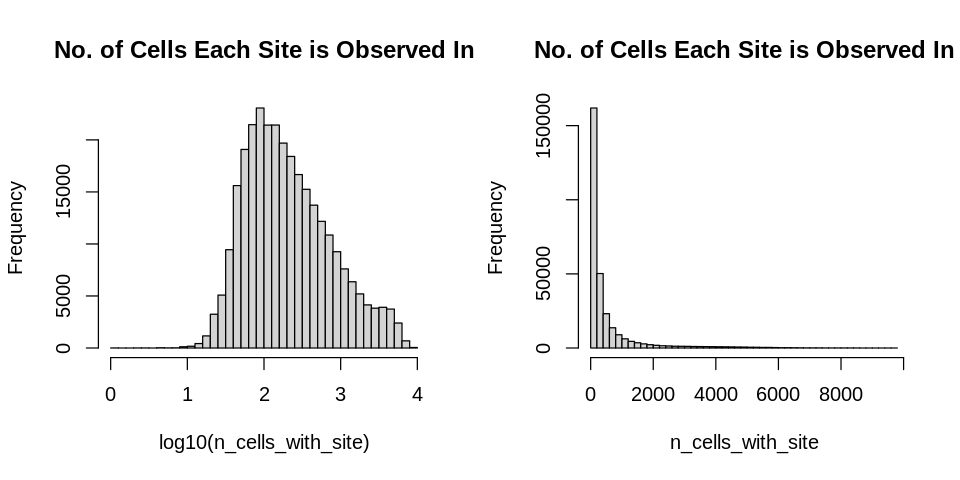

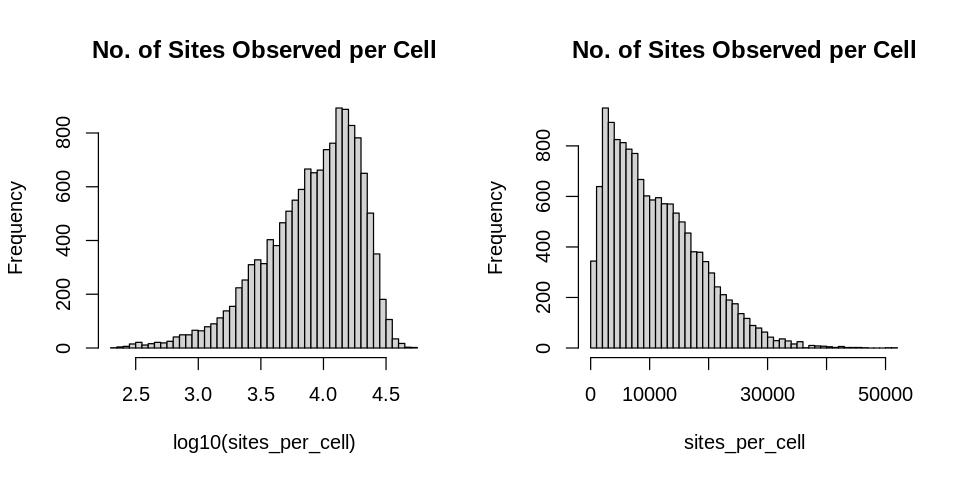

In [15]:
### Get some stats
message('Matrix size:\n', 'rows ', f_binary_mat@Dim[1], '\ncolumns ', f_binary_mat@Dim[2])

n_cells_with_site = rowSums(f_binary_mat)
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
hist(log10(n_cells_with_site), main = 'No. of Cells Each Site is Observed In', breaks = 50)
hist(n_cells_with_site, main = 'No. of Cells Each Site is Observed In', breaks = 50)

sites_per_cell = colSums(f_binary_mat)
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
hist(log10(sites_per_cell), main = 'No. of Sites Observed per Cell', breaks = 50)
hist(sites_per_cell, main = 'No. of Sites Observed per Cell', breaks = 50)

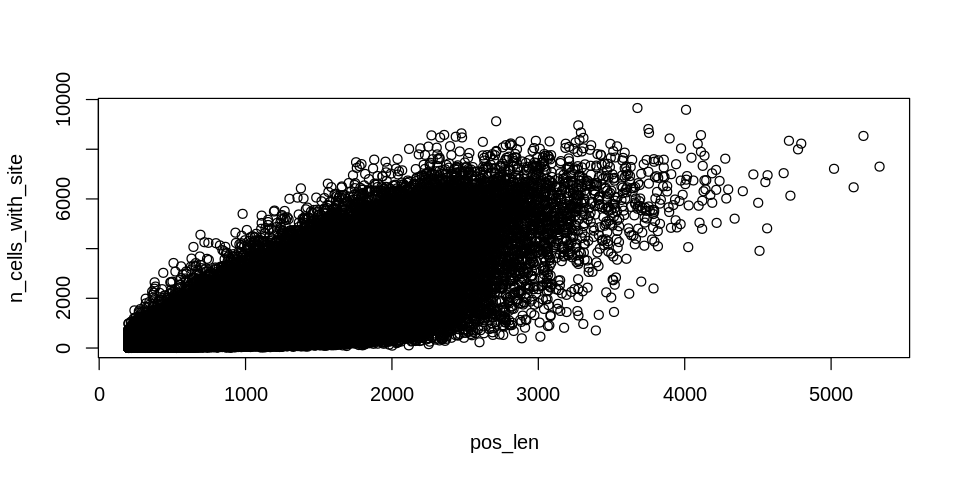

In [16]:
# compare coverage vs peak length 
pos = sapply(strsplit(rownames(f_binary_mat), split= ':'), tail , 1)
pos_len = sapply(strsplit(pos, split= '-'), function(x) as.numeric(x[2])-as.numeric(x[1]) )
par(mfrow = c(1, 1))
plot(pos_len, n_cells_with_site)
abline(v = f_binary_mat@Dim[2]*0.75)

## Remove peaks > 5k or > 75% cells

In [17]:
# f_binary_mat = f_binary_mat[pos_len < 5000 & n_cells_with_site < f_binary_mat@Dim[2]*0.75, ]
f_binary_mat = f_binary_mat[pos_len < 3000 ,  ]
### Get some stats
message('Matrix size:\n', 'rows ', f_binary_mat@Dim[1], '\ncolumns ', f_binary_mat@Dim[2])

Matrix size:
rows 295012
columns 14026



## Create object

In [18]:
### Creating a Seurat object using the windows/cell matrix
message('creating CreateSeuratObject')
so <- CreateSeuratObject(
  counts = f_binary_mat,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 5,
  min.features = 100,
  meta.data = metadata
)

creating CreateSeuratObject



In [20]:
so

An object of class Seurat 
294999 features across 14026 samples within 1 assay 
Active assay: peaks (294999 features, 0 variable features)

In [22]:
library(data.table)
for (sa in unique(metadata$sample)){
    data_to_write_out <- as.data.frame(as.matrix(subset(so, cells = rownames(subset(metadata, sample == sa)) )@assays$peaks@counts))
    fwrite(x = data_to_write_out, row.names = TRUE, file = paste0("../arrayexpress/", sa, '.tsv' ), sep = '\t')
}

In [17]:
# ### Store the path to the fragment file on disk in the Seurat object
# fragment.path <- paste0('/nfs/team292/lg18/gonads/data/scATACseq/rawdata/FCA_GND8046539/fragments.tsv.gz')
# so <- SetFragments(
#   object = so,
#   file = paste0(fragments_dir, 'fragments.tsv.gz')
# )

In [18]:
# # 1. Nucleosome banding pattern: 
# # The histogram of fragment sizes (determined from the paired-end sequencing reads) should exhibit a strong nucleosome banding pattern. 
# # We calculate this per single cell, and quantify the approximate ratio of mononucleosomal to nucleosome-free fragments (stored as nucleosome_signal). 
# # Note that by default, this is calculated only on chr1 reads (see the region parameter) to save time.
# so <- NucleosomeSignal(object = so)

In [19]:
# 2. Transcriptional start site (TSS) enrichment score. 
# The ENCODE project has defined an ATAC-seq targeting score based on the ratio of fragments centered at the TSS to fragments in TSS-flanking regions
# (see https://www.encodeproject.org/data-standards/terms/). 
# Poor ATAC-seq experiments typically will have a low TSS enrichment score. 
# We can compute this metric for each cell with the TSSEnrichment function, and the results are stored in metadata under the column name TSS.enrichment.


In [20]:
# # 3. Total number of fragments in peaks: 
# # A measure of cellular sequencing depth / complexity. 
# # Cells with very few reads may need to be excluded due to low sequencing depth. 
# # Cells with extremely high levels may represent doublets or nuclear clumps.
# so$pct_reads_in_peaks <- so$peak_region_fragments / so$passed_filters * 100

In [21]:
# 4. Fraction of fragments in peaks. 
# Represents the fraction of total fragments that fall within ATAC-seq peaks. 
# Cells with low values (i.e. <15-20%) often represent low-quality cells or technical artifacts that should be removed.


In [22]:
# # 5. Ratio reads in ‘blacklist’ sites. 
# # The ENCODE project has provided a list of blacklist regions, representing reads which are often associated with artifactual signal. 
# # Cells with a high proportion of reads mapping to these areas (compared to reads mapping to peaks) often represent technical artifacts and should be removed. 
# # ENCODE blacklist regions for human (hg19 and GRCh38), mouse (mm10), Drosophila (dm3), and C. elegans (ce10) are included in the Signac package.
# so$blacklist_ratio <- so$blacklist_region_fragments / so$peak_region_fragments
# VlnPlot(
#   object = so,
#   features = c('blacklist_ratio'),
#   pt.size = 0.1,
#   ncol = 4) + NoLegend()

In [23]:
# VlnPlot(
#   object = so,
#   features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
#   pt.size = 0.1,
#   ncol = 4) + NoLegend()

In [24]:
# ## Fragment length periodicity 
# # for all the cells, and group by cells with high or low nucleosomal signal strength. 
# # You can see that cells which are outliers for the mononucleosomal/ nucleosome-free ratio (based off the plots above) have different banding patterns. 
# # The remaining cells exhibit a pattern that is typical for a successful ATAC-seq experiment.
# so$nucleosome_group <- ifelse(so$nucleosome_signal > 3, 'NS > 3', 'NS < 3')
# PeriodPlot(object = so, group.by = 'nucleosome_group')


In [25]:
# ## Enrichment of Tn5 integration events at transcriptional start sites (TSSs) 
# # to assess the targeting of Tn5 in ATAC-seq experiments. 
# # The ENCODE consortium defined a TSS enrichment score as the number of Tn5 integration site 
# # around the TSS normalized to the number of Tn5 integration sites in flanking regions. 
# # See the ENCODE documentation for more information about the TSS enrichment score (https://www.encodeproject.org/data-standards/terms/). 
# # We can calculate the TSS enrichment score for each cell using the TSSEnrichment function in Signac.

# # create granges object with TSS positions
# gene.ranges <- genes(EnsDb.Hsapiens.v79)
# gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]
# tss.ranges <- GRanges(
#   seqnames = seqnames(gene.ranges),
#   ranges = IRanges(start = start(gene.ranges), width = 2),
#   strand = strand(gene.ranges)
# )
# seqlevelsStyle(tss.ranges) <- 'UCSC'
# tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')
# # to save time use the first 2000 TSSs
# so <- TSSEnrichment(object = so, tss.positions = tss.ranges[1:2000])
# so$high.tss <- ifelse(so$TSS.enrichment > 1, 'High', 'Low')
# TSSPlot(so, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

## Preprocessing

In [26]:
### Normalization -  term frequency-inverse document frequency (TF-IDF) 
# is a two-step normalization procedure, 
# that both normalizes across cells to correct for differences in cellular sequencing depth, 
# and across peaks to give higher values to more rare peaks
so <- RunTFIDF(so)


Performing TF-IDF normalization



In [27]:
### Feature selection: 
# The largely binary nature of scATAC-seq data makes it challenging to perform ‘variable’ feature selection, as we do for scRNA-seq. 
# Instead, we can choose to use only the top n% of features (peaks) for dimensional reduction, 
# or remove features present in less that n cells with the FindTopFeatures function. 
# Here, we will all features, though we note that we see very similar results 
# when using only a subset of features (try setting min.cutoff to ‘q75’ to use the top 25% all peaks), with faster runtimes. 
# Features used for dimensional reduction are automatically set as VariableFeatures for the Seurat object by this function.
so <- FindTopFeatures(so, min.cutoff = 'q0')

In [28]:
### Dimensional reduction: 
# We next run a singular value decomposition (SVD) on the TD-IDF normalized matrix, 
# using the features (peaks) selected above. 
# This returns a low-dimensional representation of the object.
so <- RunSVD(
  object = so,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi',
#   scale.max = 1.5, # If we want to clip to reproduce Cusanovich approach.
  fastpath=FALSE
)

Running SVD

Scaling cell embeddings



In [29]:
### Neighbors
so <- RunUMAP(object = so, reduction = 'lsi', dims = 2:20, verbose = F)
so <- FindNeighbors(object = so, reduction = 'lsi', dims = 2:20 , verbose = F)


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


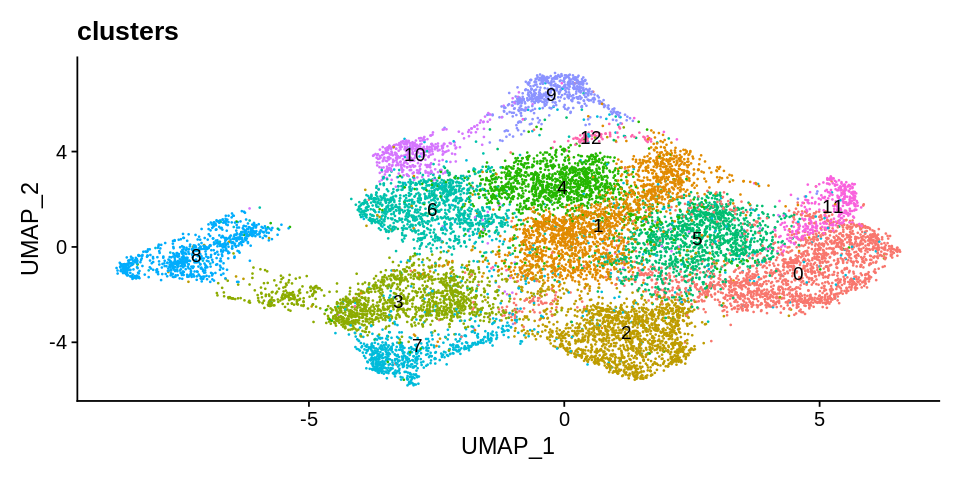

In [44]:
### Clustering
so <- FindClusters(object = so, verbose = FALSE, resolution = 0.7, algorithm = 2)
DimPlot(object = so, label = TRUE) + NoLegend() + ggtitle('clusters') 

In [45]:
p1 = DimPlot(object = so, label = TRUE) + NoLegend() + ggtitle('clusters') 
p2 = DimPlot(so, group.by = 'sample', label = T) + ggtitle('sample') 
p3 = DimPlot(so, group.by = 'day') + ggtitle('day') 
so@meta.data$treatment = factor(so@meta.data$treatment, levels = c('NoHor', 'E', 'E+P') )
p4 = DimPlot(so, group.by = 'treatment') + ggtitle('treatment') 
p5 = DimPlot(so, group.by = 'donor') + ggtitle('donor') 
p5 = DimPlot(so, group.by = 'inhibitor') + ggtitle('inhibitor') 
p6 = DimPlot(so, group.by = 'cellatac_win_cluster', label = TRUE) + ggtitle('cellatac_win_cluster') 

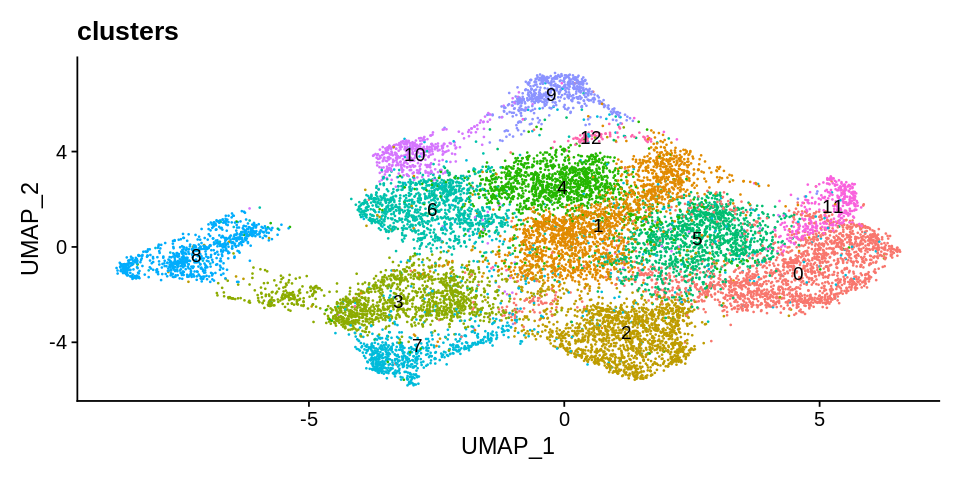

In [46]:
p1

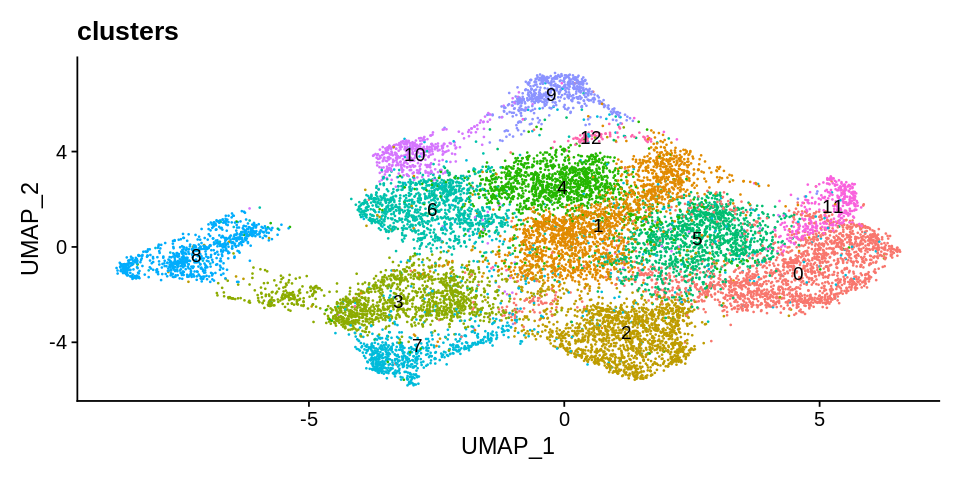

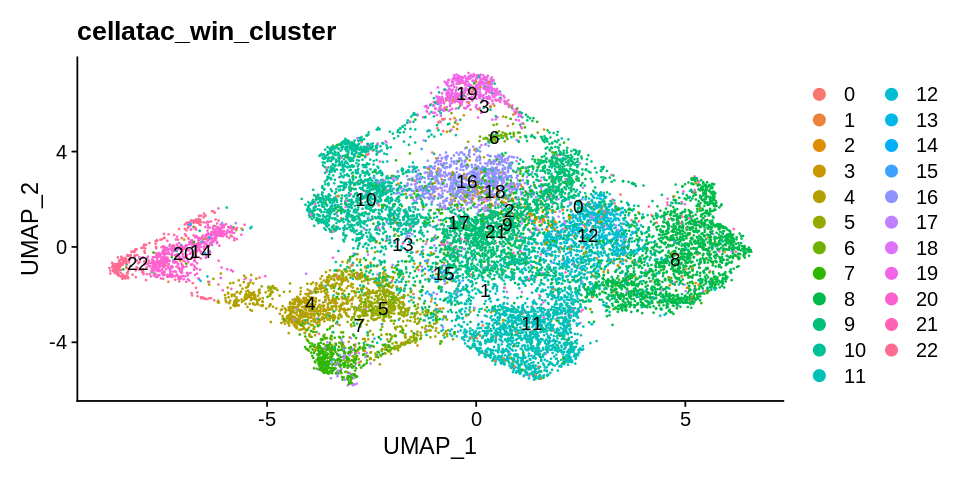

In [47]:
p1
p6

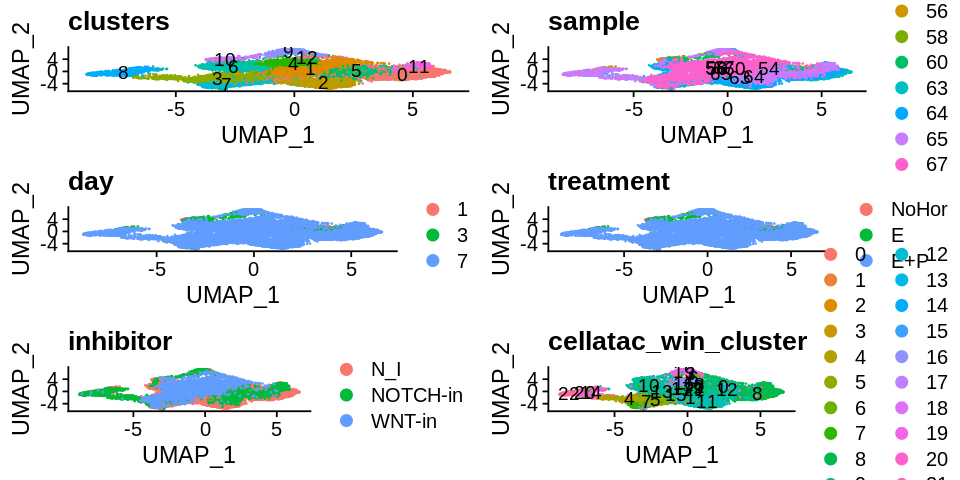

In [48]:
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 2)
# plot_grid(p1, p2, p3, p4, p5, p5s, ncol = 2)
ggsave(filename = paste0(outdir, 'general/umap_preintegration.pdf'), width = 10, height = 12)

In [ ]:
saveRDS(so, file = paste0(outdir, '/data/M0_preintegration_noclipped.rds'))

In [ ]:
# so = readRDS(file = paste0(outdir, '/data/M0_preintegration_noclipped.rds'))

## General plots

In [ ]:
p1 = FeaturePlot(object = so, features = 'total') + NoLegend() + ggtitle('total')
p1

In [ ]:
p2 = FeaturePlot(object = so, features = 'nFeature_peaks') + NoLegend() + ggtitle('nFeature_peaks')
p2

In [ ]:
p3 = FeaturePlot(object = so, features = 'mitochondrial') + NoLegend() + ggtitle('mitochondrial')
p3

In [ ]:
p4 = FeaturePlot(object = so, features = 'DNase_sensitive_region_fragments') + NoLegend() + ggtitle('DNase_sensitive_region_fragments')
p4

In [ ]:
p5 = FeaturePlot(object = so, features =  'TSS_fragments') + NoLegend() + ggtitle('TSS_fragments')
p5

In [ ]:
p6 = FeaturePlot(object = so, features = 'enhancer_region_fragments') + NoLegend() + ggtitle('enhancer_region_fragments')
p6

In [ ]:
p7 = FeaturePlot(object = so, features = 'peak_region_fragments') + NoLegend() + ggtitle('peak_region_fragments')
p7

In [ ]:
# donor
p1 = ggplot(so@meta.data, aes(x = seurat_clusters, fill = inhibitor) ) + geom_bar(position = 'fill') + theme_bw(20)
p2 = ggplot(so@meta.data, aes(x = inhibitor, fill = seurat_clusters) ) + geom_bar(position = 'fill') + theme_bw(20)
CombinePlots(list(p1,p2), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_inhibitor.pdf'), width = 20, height = 7)


# treatment
p1 = ggplot(so@meta.data, aes(x = seurat_clusters, fill = treatment) ) + geom_bar(position = 'fill') + theme_bw(20)
p2 = ggplot(so@meta.data, aes(x = treatment, fill = seurat_clusters) ) + geom_bar(position = 'fill') + theme_bw(20)
CombinePlots(list(p1,p2), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_treatment.pdf'), width = 20, height = 7)


In [10]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] cowplot_1.0.0             pheatmap_1.0.12          
 [3] ggplot2_3.3.1             RColorBrewer_1.1-2       
 [5] Matrix_1.2-18             dplyr_1.0.0              
 [7] EnsDb.Hsapiens.v79_2.99.0 ensembldb_2.12.1         
 [9] AnnotationFilter_1.12.0   GenomicFeatures_1.40.0 